In [1]:
import h5py
import torch
import pandas as pd
import numpy as np
from tangermeme.utils import characters
from tangermeme.seqlet import tfmodisco_seqlets
from tangermeme.plot import plot_logo
from tangermeme.utils import one_hot_encode
from tangermeme.deep_lift_shap import deep_lift_shap, _nonlinear
import torch, torch.nn as nn, torch.fx as fx, copy
import copy
import matplotlib.pyplot as plt
import statsmodels
import modiscolite

In [2]:
hits_byseq = pd.read_csv("TF-Modisco-lite_results/Hk_manual_hits/high_hits.csv")

valid_seqs = hits_byseq["sequence_name"].unique()

hits_byseq = dict(tuple(hits_byseq.groupby("sequence_name")))



In [3]:
high_df = pd.read_csv("../experimental_library_generation/Binned_libraries/Hk_full_data/high_df.csv")


In [4]:
import ast
import numpy as np
import torch

TARGET_COLS = ["Cluster_foreground", "Scaled_foreground", "Avg_background"]

def str_tensor_to_torch(s: str, dtype=torch.float32, device=None):
    # Accepts "tensor([...])" or just "[...]"
    if s is None:
        return None
    s = str(s).strip()
    if s.startswith("tensor(") and s.endswith(")"):
        inner = s[len("tensor("):-1]
    else:
        inner = s
    # Keep only the bracketed numeric literal, drop dtype/device hints
    first_brack = inner.find('[')
    if first_brack != -1:
        inner = inner[first_brack:]
    data = ast.literal_eval(inner)  # safe parse to Python lists
    arr = np.array(data, dtype=np.float32 if dtype is None else None)
    return torch.tensor(arr, dtype=dtype, device=device) if device is not None else torch.tensor(arr, dtype=dtype)

def to_torch(v, dtype=torch.float32, device=None):
    if v is None:
        return None
    if isinstance(v, str):
        return str_tensor_to_torch(v, dtype=dtype, device=device)
    if isinstance(v, torch.Tensor):
        return v.to(dtype=dtype, device=device) if device else v.to(dtype=dtype)
    if isinstance(v, (list, tuple, np.ndarray)):
        return torch.tensor(v, dtype=dtype, device=device)
    # Fallback: try to wrap scalar
    try:
        return torch.tensor(v, dtype=dtype, device=device)
    except Exception:
        return v  # leave as-is if not numeric

def restore_tensor_columns(df, cols=TARGET_COLS, dtype=torch.float32, device=None):
    for col in cols:
        if col in df.columns:
            df[col] = [to_torch(v, dtype=dtype, device=device) for v in df[col].tolist()]
    return df

# Apply to your DataFrame
high_df = restore_tensor_columns(high_df, cols=["Cluster_foreground", "Scaled_foreground", "Avg_background"])
high_ohe_list = high_df["ohe_seq"].values
high_att_list = high_df["Scaled_foreground"].values
# If needed for low_df/mid_df as well:
# low_df = restore_tensor_columns(low_df)
# mid_df = restore_tensor_columns(mid_df)


In [60]:
hits_byseq[25]

,motif_name,motif_idx,sequence_name,start,end,strand,score,p-value,q-value,test_idx
61,pos_patterns.pattern_0,0,25,150,163,-,13.381292,0.000022,0.000113,286195
62,pos_patterns.pattern_0,0,25,180,193,-,12.418843,0.000041,0.000139,286195
63,pos_patterns.pattern_5,5,25,238,248,+,9.744175,0.000057,0.000231,286195
64,pos_patterns.pattern_4,4,25,202,232,+,7.716361,0.000164,0.000325,286195


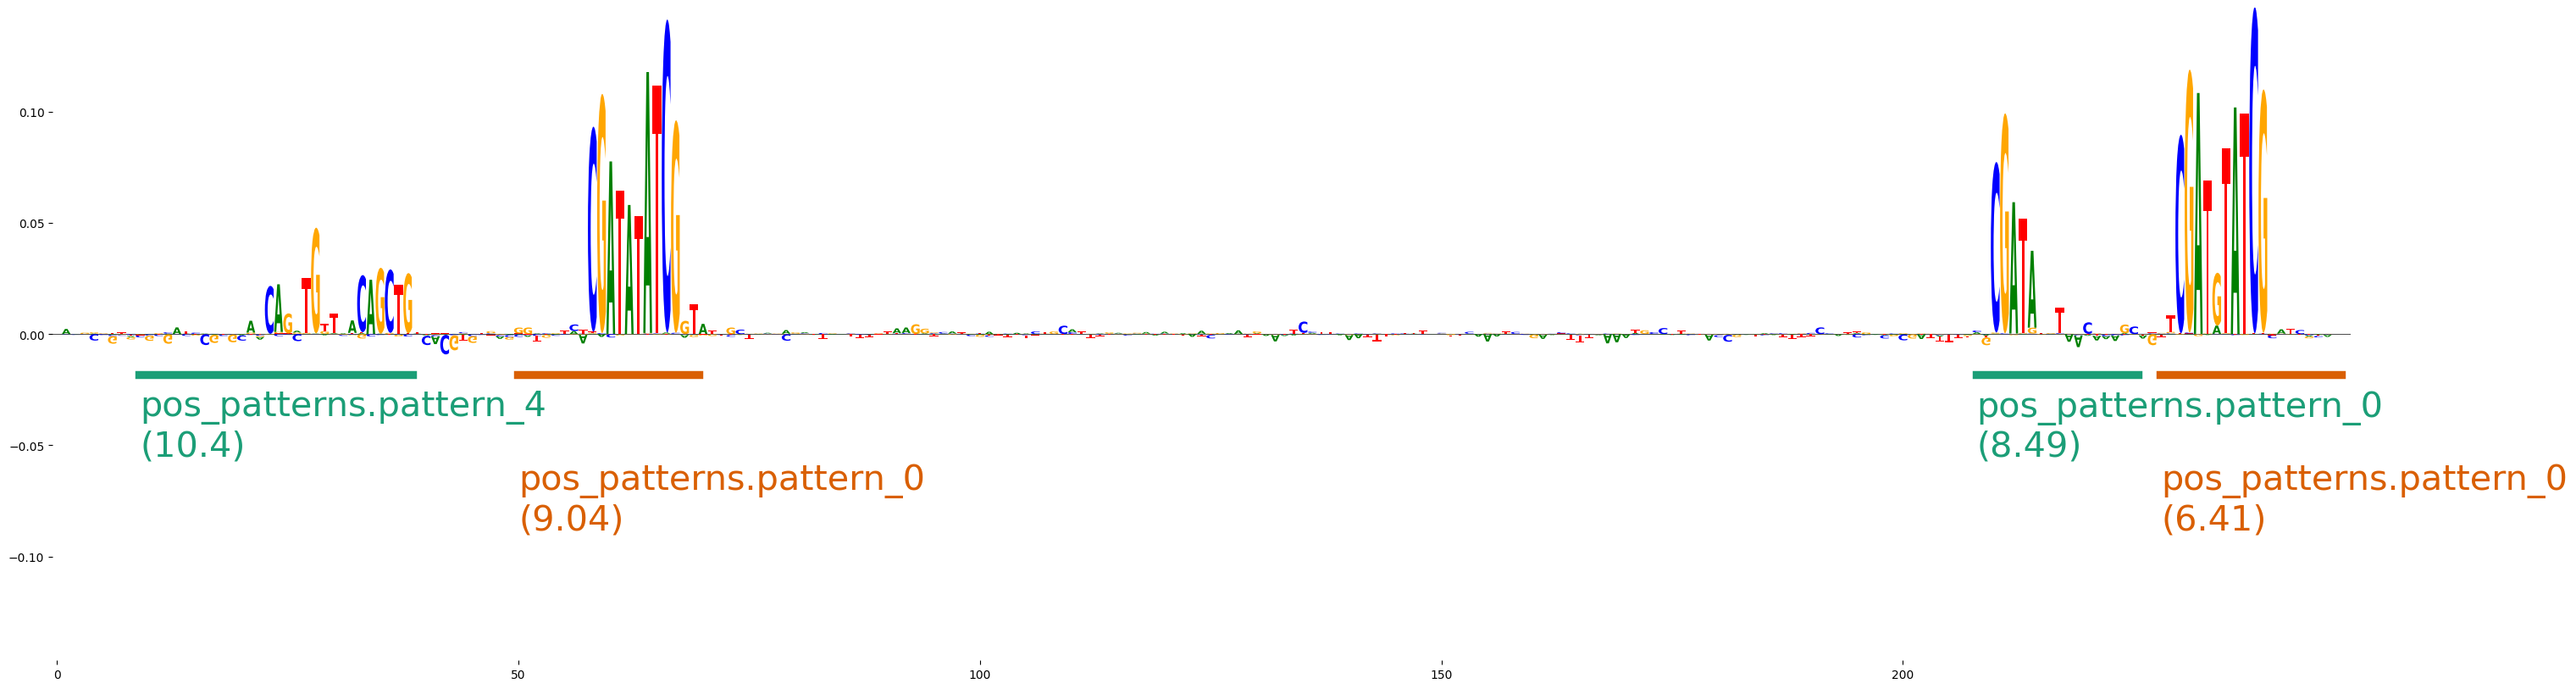

In [5]:
fig, ax = plt.subplots(figsize=(35, 10))

plot_logo(high_att_list[7].T, annotations=hits_byseq[7], ax=ax, annot_cmap = "Dark2")

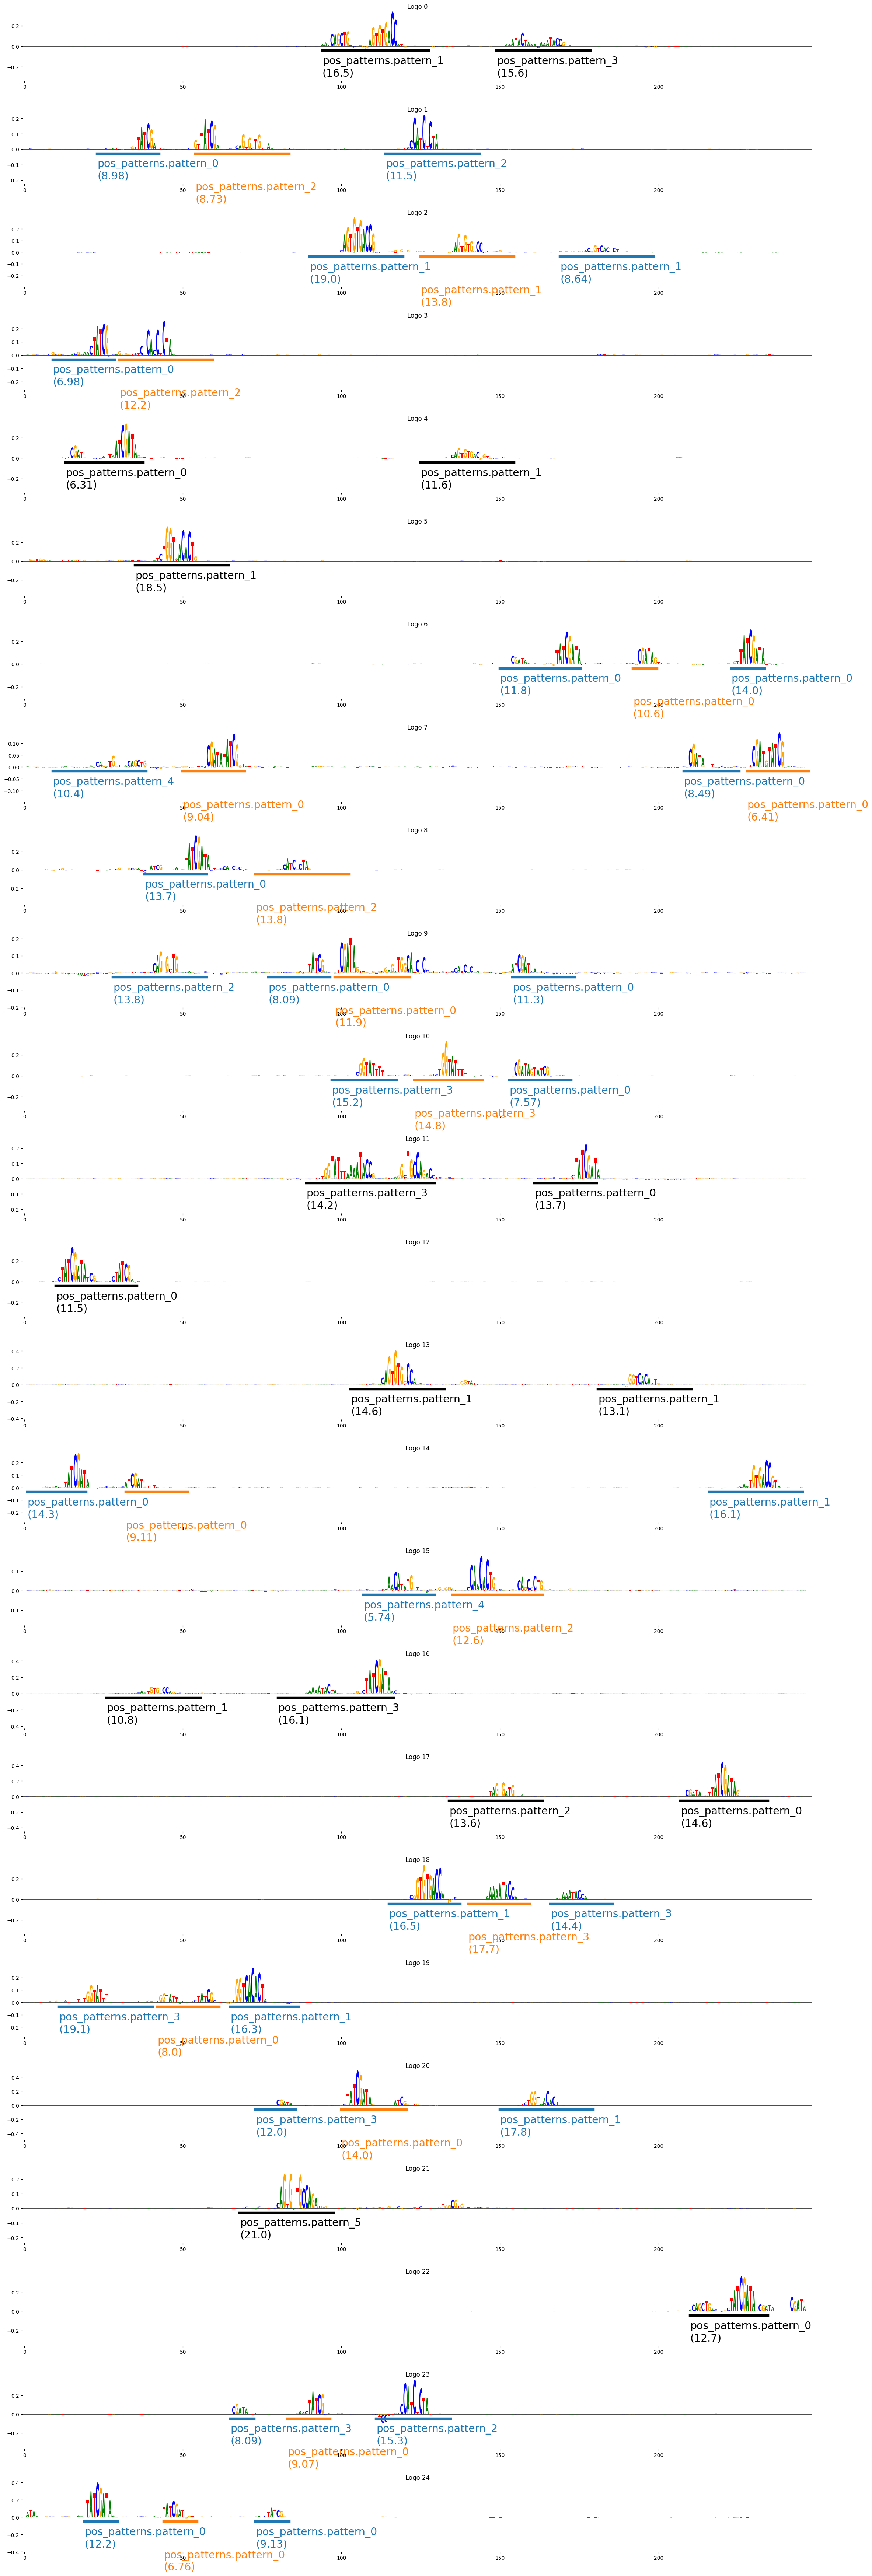

In [62]:
import matplotlib.pyplot as plt

# Create a figure with 5 rows and 5 columns of subplots
fig, axs = plt.subplots(25, 1, figsize=(24, 70))

# Flatten the axes array for easy indexing
axs = axs.flatten()

first = valid_seqs[0:25]

for count, i in enumerate(first):
    i = int(i)
    ax = axs[count]
    plot_logo(high_att_list[i].T, annotations=hits_byseq[i], ax=ax, annot_cmap="tab10")
    ax.set_title(f"Logo {i}")

plt.tight_layout()
plt.show()
